<a href="https://colab.research.google.com/github/pinkfloydisch/SEIR/blob/master/COVIDrandom_search_Germany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SIR-X model


The SIR-X model http://rocs.hu-berlin.de/corona/docs/forecast/results_by_country/ is a simple but seems to be accurate model.

The population is described by **S** (fraction of people suspectible to the infection), **I** (fraction of people infected and spreading the infection), (**R** which is neither suspectible nor infected), and **X** (the number of "quarantineed" people). 

$X$ is roughly the number of cases reported by each country. 

The equations describing the evolution of $S$, $I$, $R$ and $X$ are self-explanatory:

$$\frac{dS}{dt} = -\alpha S I - k_0 S,  \quad \frac{dI}{dt} = \alpha S I - \beta I - k_0 I - k I, 
\quad \frac{dX}{dt} = (k_0 + k) I, \quad \frac{dR}{dt} = k_0 S + \beta I.$$

The first equation controls the spread of the infection (the growth is proportional to the probability of meeting of $S$ and $I$), 
the constant $\beta$ controls the recovery / death process (and is roughly $\beta \approx \frac{1}{T}$, where $T$ is the characteristic time of the decease). 

The parameters $k_0$ and $k$ represent the measures taken: $k_0$ corresponds to social distancing / contract tracing, whereas $k$ controls the quarantine process for symptomatic individuals

To fit the model, one has to find the parameters of it $\alpha, \beta, k_0, k$ and the initial number of infected individuals $I_0$ such that the $X(t)$ approximates the observed cases $C(t)$. The true number of potentially infected people $I(t)$ can be much larger. 

Several optimization techniques can be used. We tried gradient-free optimization package **nevergrad**, however, 
right now we are doing the Bayesian optimization in order to give not only the values of parameters, but also the risk values. 


The data collection below is taken form a nice [Google Colab notebook](https://colab.research.google.com/drive/15R6bXKW--TSMXClMfHql8zU0ePOLEoa3)

In [0]:
Country = 'Germany'

population = {"Italy" : 60317000, "China" : 1404328000, "Germany" : 83783942}

starting_threshold = 10
search_attempts = 1000



In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
!pip install pymc
import pymc as pm
from scipy.integrate import odeint
from concurrent import futures

%matplotlib inline


     |████████████████████████████████| 389kB 4.5MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp36-cp36m-linux_x86_64.whl size=1275938 sha256=b3eb4190c503f470fd21c09bbf97776be63c0cffac788d2cb9c640d6f853a49d
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.sort_values(covid_confirmed.columns[-1]).tail()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,...,22304,25233,29155,32964,37575,40174,44550,52128,56989,59105,64338,68605,70478,74390,78167,82048,86334,90676,93790,120633,124298,129257,132473,144944,146923,146906,151808,154188,156921,154715,157026,158636,160292,160847,164589,167605,165093,165764,165764,166976
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,...,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718,38168,41903,47806,51608,55242,60733,65077,73758,78991,84279,88621,93873,98476,103093,108692,114217,120067,124743,129044,133495,138078,143464,148377,152840,157149,161145,165221,171253,177454,182260
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,...,69176,74386,80589,86498,92472,97689,101739,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626,147577,152271,156363,159516,162488,165155,168941,172434,175925,178972,181228,183957,187327,189973,192994,195351,197675,199414,201505,203591,205463,207428,209328
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,6,13,...,39885,49515,57786,65719,73235,80110,87956,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222,158273,163027,166831,170099,172541,177644,184948,190839,191726,198674,200210,204178,208389,213024,202990,205905,207634,209465,210773,212917,213435,213435,216582
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,...,53736,65778,83836,101657,121465,140909,161831,188172,213242,243622,275367,308650,336802,366317,397121,428654,462780,496535,526396,555313,580619,607670,636350,667592,699706,732197,758809,784326,811865,840351,869170,905358,938154,965785,988197,1012582,1039909,1069424,1103461,1132539


In [4]:
data_country_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_country_confirmed.shape[0]), dtype=np.int64)
data[0] = data_country_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

data[0][-1]

164967

In [5]:
data[0]

array([     0,      0,      0,      0,      0,      1,      4,      4,
            4,      5,      8,     10,     12,     12,     12,     12,
           13,     13,     14,     14,     16,     16,     16,     16,
           16,     16,     16,     16,     16,     16,     16,     16,
           16,     16,     17,     27,     46,     48,     79,    130,
          159,    196,    262,    482,    670,    799,   1040,   1176,
         1457,   1908,   2078,   3675,   4585,   5795,   7272,   9257,
        12327,  15320,  19848,  22213,  24873,  29056,  32986,  37323,
        43938,  50871,  57695,  62095,  66885,  71808,  77872,  84794,
        91159,  96092, 100123, 103374, 107663, 113296, 118181, 122171,
       124908, 127854, 130072, 131359, 134753, 137698, 141397, 143342,
       145184, 147065, 148291, 150648, 153129, 154999, 156513, 157770,
       158758, 159912, 161539, 163009, 164077, 164967])

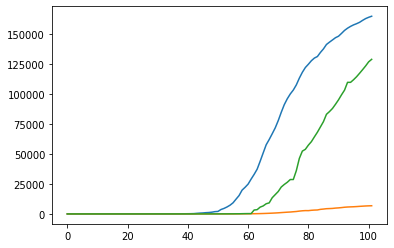

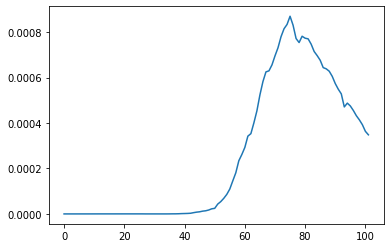

In [6]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

In [0]:
@jit
def sirx_rhs(x, t, alpha, gamma, mu):
    S, I, X, R = x
    dsdt = -alpha*S*I 
    didt = (alpha*S -  (gamma + mu))*I
    dxdt = (mu)*I
    dRdt = gamma*I
    return np.array([dsdt, didt, dxdt, dRdt])


def base_sirx_model_rhs(x, params):
    alpha, gamma , mu= params
    S, I, X, R = x
    dsdt = -alpha*S*I 
    didt = alpha*S*I - gamma*I - mu*I
    dxdt = mu*I
    dRdt = gamma*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol


In [8]:
#vals = []

data1 = data[0]
data1 = data1[data1>=starting_threshold]
data_offset = 0
# data_offset = np.argwhere(data1 > 100)[0][0]

print(data_offset)
# data1 = data1/population[Country]
#plt.plot(data1)

#true_cases = data_normed_only_conf[-20:]
#true_cases = data_normed_only_conf[data[0] >= 3]
#true_cases = data_normed[0][data[0] >= 3]
true_cases = data1/population[Country]


def obs(alpha_MC, gamma_MC, mu_MC, X0_MC, cf = 1, N = len(true_cases), type_ret=2):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        # res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        res = base_sirx_model_odeint((1.0 - X0_MC , true_cases[0], X0_MC , 0.0), dt, num, (alpha_MC, gamma_MC, mu_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    
def obs2(alpha_MC, gamma_MC, mu_MC, X0_MC, cf = 1, N = len(true_cases)):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        # res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        res = base_sirx_model_odeint((1.0 - X0_MC , true_cases[0], X0_MC , 0.0), dt, num, (alpha_MC, gamma_MC, mu_MC))
        rr = res.T[::cf]
        #print(rr)
        #vals.append(rr)
        return rr

    

def loss_fn_weighted(alpha, gamma, mu, X0):
    # Weighted variance
    loss_val = np.linalg.norm( (obs(alpha, gamma, mu, X0)[data_offset:] - true_cases[data_offset:])*data1[data_offset:] )
    return loss_val

def loss_fn_equal_weight(alpha, gamma, mu, X0):
    # Equal weight variance
    loss_val = np.linalg.norm(obs(alpha, gamma, mu, X0)[data_offset:] - true_cases[data_offset:])
    return loss_val

_ = """
num_days = len(true_cases)-1
times = np.linspace(0, num_days, num_days+1)

def compute_fit(alpha, beta, k0, k, I0):
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    predicted_cases = sol[:, 2]
    return np.linalg.norm(true_cases-predicted_cases)


def predict(alpha, beta, I0, k0, k, num_days):
    times = np.linspace(0, num_days, num_days+1)
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    return sol

"""

0


In [0]:
def show_match(vals, new_figure=True, label='Predicted'):
    alpha_g, gamma_g, mu_g, X0_g = vals
    num = len(true_cases)+3
    solution = population[Country]*obs(alpha_g, gamma_g, mu_g, X0_g, N=num, cf=1)

    time_scale = np.linspace(1, num, num)
    time_scale_true = np.linspace(1, len(true_cases), len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title('Match between predicted and actual cases');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    # plt.yscale('log')
    for i in (3,2,1):
        print("{}: day {}: number of cases:{:.0f}".format(label, 4-i, solution[-i] - solution[-i-1]))
        
def present_solution_many(vals, num_days=120, new_figure=True, label_prefix=None):
    alpha_g, gamma_g, mu_g, X0_g = vals
    solution = population[Country]*obs(alpha_g, gamma_g, mu_g, X0_g, N=num_days, cf=1)
    # print(f"{label}: Max cases: {max(solution):.0f}")
    if label_prefix is None:
        label_prefix = ""

    cases_max = solution[-1]/1000
    label = label_prefix + f"{cases_max:6.1f}"
    time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
    time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title(Country + ': Reported cases model');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    plt.text(time_scale[-10], solution[-1], label)
    # plt.yscale('log')

def present_solution(vals, num_days=120, new_figure=True, label="Predicted"):
    alpha_g, gamma_g, mu_g, X0_g = vals
    solution = population[Country]*obs(alpha_g, gamma_g, mu_g, X0_g, N=num_days, cf=1)
    print(f"{label}: Max cases: {max(solution):.0f}")

    time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
    time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title(Country + ': Reported cases model');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    plt.text(time_scale[-10], solution[-1], label)
    # plt.yscale('log')


def prognosis(vals, num_days = 120, new_figure=True, several_scenarios=True, label_prefix=None):
    alpha_g, gamma_g, mu_g, X0_g = vals
    start = obs2(alpha_g, gamma_g, mu_g, X0_g, N=len(true_cases))[:, -1]
    dt = 1.0
    res1 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, gamma_g, mu_g))
    if several_scenarios:
        res2 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, gamma_g, mu_g))
        res3 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, gamma_g, mu_g))
    
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.title(Country + ': Potentially infected model')
        plt.legend()
    if label_prefix is not None: 
        label_prefix += ": "
    else:
        label_prefix = ''
    plt.plot(res1[:, 1]*population[Country], label=f'{label_prefix}Current measures')
    if several_scenarios:
        plt.plot(res2[:, 1]*population[Country], label=f'{label_prefix}1% strictly isolated')
        plt.plot(res3[:, 1]*population[Country], label=f'{label_prefix}10% strictly isolated')
    print(f"{label_prefix}Infected now: {res1[0, 1]*population[Country]:.0f}")
    if several_scenarios:
        print(f"{label_prefix}Max infected: {max(res1[:, 1]*population[Country]):.0f} vs {max(res2[:, 1]*population[Country]):.0f} vs {max(res3[:, 1]*population[Country]):.0f}")
    else:
        print(f"{label_prefix}Max infected: {max(res1[:, 1]*population[Country]):.0f}")

def prognosis_many(vals, num_days = 120, label_prefix=None, new_figure=True):
    alpha_g, gamma_g, mu_g, X0_g = vals
    start = obs2(alpha_g, gamma_g, mu_g, X0_g, N=len(true_cases))[:, -1]
    dt = 1.0
    res1 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, gamma_g, mu_g))
    
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.title(Country + ': Potentially infected model')
        plt.legend()
    if label_prefix is not None: 
        label_prefix += ": "
    else:
        label_prefix = ''
    
    solution = res1[:, 1]*population[Country]/1000.0
    infected_now = solution[0]
    infected_max = max(solution)
    infected_max_x = np.argmax(solution)
    
    label = f"{label_prefix}{infected_now:0.1f}, max {infected_max:0.1f}"
    plt.plot(res1[:, 1]*population[Country], label=label)
    plt.text(infected_max_x, infected_max*1000.0, label_prefix)

Trying to optimize the solution using gradient descent in the small vicinity

In [0]:
bounds = ((0.0, 10.0),  (0.0, 1e-1), (0, 0.1), (true_cases[0], true_cases[0]*100))
bounds_low = np.array([b[0] for b in bounds])
bounds_high = np.array([b[1] for b in bounds])

def cost_fn(x):    
    for v,b in zip(x,bounds):
        l,r = b
        if v < l or v > r:
            return 1e100
    return loss_fn_weighted(*x)

In [0]:
from scipy import optimize

In [0]:
class VectorIterator:
    def __init__(self, N, low = -1, high = 1):
        self.vector = np.full(N, low)
        self.low = low
        self.high = high
    def __iter__(self):
        self.first = True
        return self
    def __next__(self):
        if self.first:
            self.first = False
            return self.vector
            
        for i,x in enumerate(self.vector):
            if x == self.high:
                self.vector[i] = self.low
            else:
                self.vector[i] += 1
                return self.vector
        raise StopIteration

In [0]:
_local_minimum_factor = 1e-2
def is_local_minimum(fn, x):
    step = x*_local_minimum_factor
    vi = VectorIterator(len(x))
    m = fn(x)
    for v in vi:
        y = x + v*step
        val_y = fn(y)
        if val_y < m:
            return False, (y, val_y)
    return True, None

In [0]:
def simple_descend(start, iters = 2000):
    v = start
    for i in range(iters):
        res, nxt = is_local_minimum(cost_fn, v)
        if res:
            print(f"Local minimum on step {i}")
            break
        else:
            v = nxt[0]
    return v

In [0]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [0]:
import itertools

In [17]:
random_search_results = []
for i in range(search_attempts):
    if 0 == i%10:
        update_progress(i/search_attempts)
    x = np.random.uniform(bounds_low, bounds_high)
    opt = optimize.minimize(cost_fn, x, method='Nelder-Mead')
    if not opt.success:
        continue
    random_search_results.append((opt.fun, opt.x))
update_progress(1)

Progress: [####################] 100.0%


In [18]:
random_search_results = sorted(random_search_results, key=lambda v: v[0])
filtered_results = filter(lambda res: res[1][3] < bounds[-1][1], random_search_results)
best = list(itertools.islice(filtered_results, 20))
for i,(f,(a,g,m,x0)) in enumerate(best):
    print(f"{i+1}: Alpha = {a}, Mu: {m}, Gamma: {g}\n ")

1: Alpha = 0.3863600632708736, Mu: 0.00013025532026970701, Gamma: 0.06020893193319314
 
2: Alpha = 0.38647553408213375, Mu: 0.00013029994437698607, Gamma: 0.0601538245007251
 
3: Alpha = 0.38648316392988336, Mu: 0.00013027626512455694, Gamma: 0.06013108955430435
 
4: Alpha = 0.3866668355283308, Mu: 0.00013034764751439446, Gamma: 0.06006190583771924
 
5: Alpha = 0.38672163481345756, Mu: 0.00013033538591204942, Gamma: 0.0600381692180455
 
6: Alpha = 0.3867435175518039, Mu: 0.00013036529143741957, Gamma: 0.060041330463092235
 
7: Alpha = 0.3867993914739155, Mu: 0.00013037127970339478, Gamma: 0.06000927821300045
 
8: Alpha = 0.38682100393527735, Mu: 0.0001303883098701891, Gamma: 0.0599955152544341
 
9: Alpha = 0.3866215613817495, Mu: 0.00012935397012522616, Gamma: 0.059473073405341276
 
10: Alpha = 0.38692508619390104, Mu: 0.00013045715782204255, Gamma: 0.05998057527276471
 
11: Alpha = 0.3869274762481985, Mu: 0.00013039433703254484, Gamma: 0.05993241480729405
 
12: Alpha = 0.3869391688209

No handles with labels found to put in legend.


1: day 1: number of cases:965
1: day 2: number of cases:909
1: day 3: number of cases:857
2: day 1: number of cases:966
2: day 2: number of cases:910
2: day 3: number of cases:858
3: day 1: number of cases:966
3: day 2: number of cases:911
3: day 3: number of cases:858
4: day 1: number of cases:967
4: day 2: number of cases:911
4: day 3: number of cases:859
5: day 1: number of cases:967
5: day 2: number of cases:911
5: day 3: number of cases:859
6: day 1: number of cases:967
6: day 2: number of cases:911
6: day 3: number of cases:859
7: day 1: number of cases:967
7: day 2: number of cases:912
7: day 3: number of cases:860
8: day 1: number of cases:968
8: day 2: number of cases:912
8: day 3: number of cases:860
9: day 1: number of cases:976
9: day 2: number of cases:921
9: day 3: number of cases:868
10: day 1: number of cases:968
10: day 2: number of cases:912
10: day 3: number of cases:860
11: day 1: number of cases:968
11: day 2: number of cases:913
11: day 3: number of cases:861
12: 

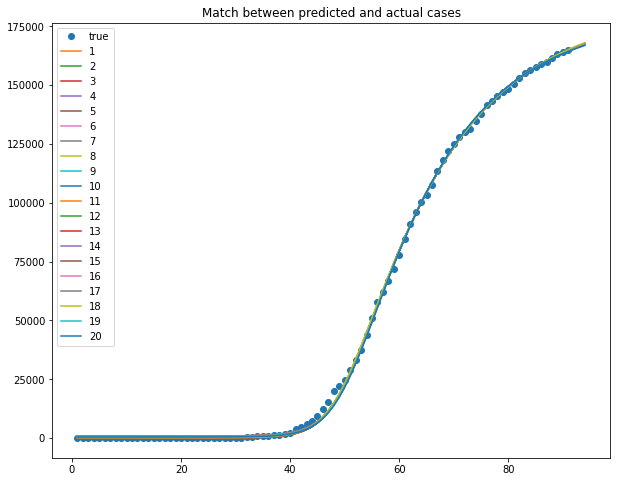

In [19]:
new_figure = True
for i,(f,x) in enumerate(best):
    show_match(x, new_figure=new_figure, label=f"{i+1}")
    new_figure = False
plt.legend()
        

No handles with labels found to put in legend.


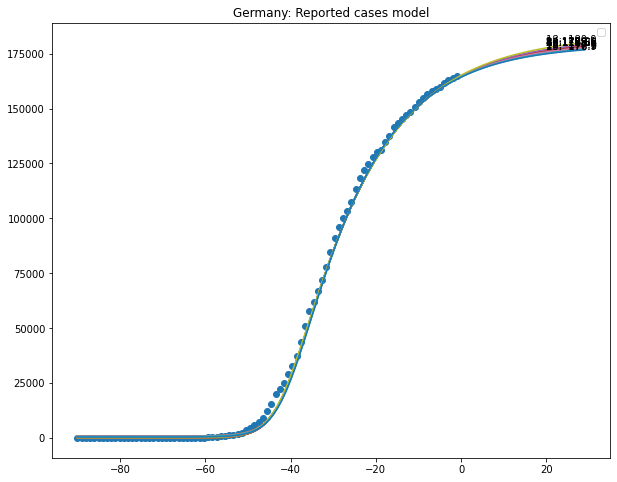

In [20]:
new_figure = True
for i,(f,x) in enumerate(best):
    present_solution_many(x, new_figure=new_figure, num_days=120, label_prefix=f"{i+1}: ")
    new_figure = False
#plt.legend()

No handles with labels found to put in legend.


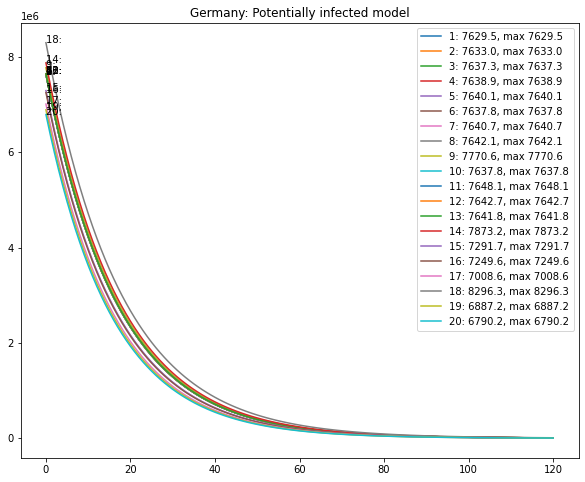

In [21]:
new_figure = True
for i,(f,x) in enumerate(best):
    prognosis_many(x, new_figure=new_figure, label_prefix=f"{i+1}")
    new_figure = False
plt.legend()

In [0]:
vals5 = best[0][1]

No handles with labels found to put in legend.


Infected now: 7629519
Max infected: 7629519 vs 7629519 vs 7629519


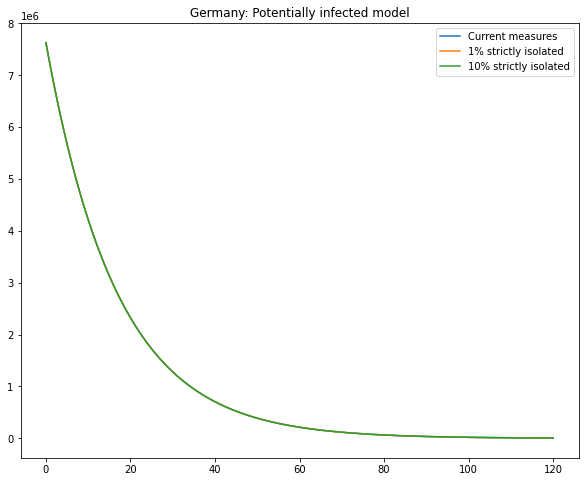

In [23]:
prognosis(vals5)
plt.legend()

In [0]:
tmp_best = best[1][1]

In [0]:
_local_minimum_factor = 1e-4
if not is_local_minimum(cost_fn, tmp_best)[0]:
    tmp_best = simple_descend(tmp_best, 1000)

No handles with labels found to put in legend.


Infected now: 7673466
Max infected: 7673466 vs 7673466 vs 7673466


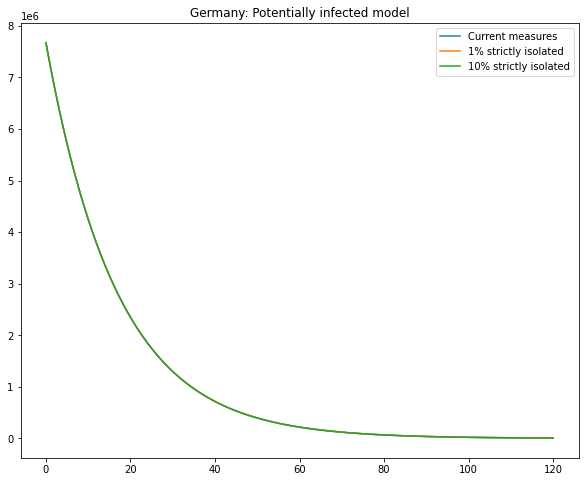

In [26]:
prognosis(tmp_best)
plt.legend()